In [1]:
%reload_ext memory_profiler
import autograd.numpy as anp
from qoc import grape_schroedinger_discrete
from qoc.standard import (TargetStateInfidelity,
                          conjugate_transpose,
                          get_annihilation_operator,
                          get_creation_operator,
                          SIGMA_Z,
                          generate_save_file_path, )
from memory_profiler import profile
import numpy as np

from qutip import (qsave,qload)
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix
%matplotlib inline

In [7]:


# Define the system.
def get_memory_manually(N,l):
    """
    0_transmon_pi.py - This module demonstrates
    a simple example of grape on the schroedinger equation
    using time discrete control parameters to evolve a transmon qubit
    form the ground state to the first excited state.
    """


    HILBERT_SIZE = l
    # E.q. 19 (p. 6) of https://arxiv.org/abs/1904.06560.
    # E.q. 19 (p. 6) of https://arxiv.org/abs/1904.06560.
    diagnol=np.arange(HILBERT_SIZE)
    up_diagnol = np.sqrt(diagnol)
    low_diagnol = np.sqrt(np.arange(1, HILBERT_SIZE + 1))
    state = (1 / np.sqrt(HILBERT_SIZE)) * np.ones(HILBERT_SIZE)
    data = [low_diagnol, diagnol, up_diagnol]
    offsets = [-1, 0, 1]
    H_SYSTEM_0= dia_matrix((data, offsets), shape=(HILBERT_SIZE, HILBERT_SIZE))
    sigmax = dia_matrix(([low_diagnol, up_diagnol], [-1, 1]), shape=(HILBERT_SIZE, HILBERT_SIZE))
    # Only real control amplitutdes are supported!
    hamiltonian = lambda controls, time: (H_SYSTEM_0
                                          + controls[0] * sigmax)

    # Define the problem.
    CAVITY_VACUUM = anp.zeros((l, 1))
    CAVITY_ZERO = anp.copy(CAVITY_VACUUM)
    CAVITY_ZERO[0, 0] = 1
    CAVITY_ONE = anp.copy(CAVITY_VACUUM)
    CAVITY_ONE[1, 0] = 1
    CAVITY_VACUUM= anp.zeros((l, 1))

    INITIAL_STATE_0=anp.copy(CAVITY_VACUUM)
    INITIAL_STATE_0[0,0]=1
    TARGET_STATE_0 = anp.copy(CAVITY_VACUUM)
    TARGET_STATE_0[1,0]=1
    INITIAL_STATES = anp.stack((INITIAL_STATE_0,), axis=0)
    TARGET_STATES = anp.stack((TARGET_STATE_0,), axis=0)
    COSTS = [TargetStateInfidelity(TARGET_STATES)]

    # Define the optimization.
    COMPLEX_CONTROLS = False
    CONTROL_COUNT = 1
    EVOLUTION_TIME = 1e-6  # nanoseconds
    CONTROL_EVAL_COUNT = SYSTEM_EVAL_COUNT = N + 1
    ITERATION_COUNT = 1

    # Define output.
    LOG_ITERATION_STEP = 1
    SAVE_ITERATION_STEP = 1
    SAVE_PATH = "./out"
    SAVE_FILE_NAME = "transmon_pi"
    SAVE_FILE_PATH = generate_save_file_path(SAVE_FILE_NAME, SAVE_PATH)
    CONTROL_HAMILTONIAN = [sigmax]

    manual_parameter = {"control_hamiltonian": CONTROL_HAMILTONIAN, "manual_gradient_mode": True,"tol":1e-6}

    def main():
        result = grape_schroedinger_discrete(CONTROL_COUNT, CONTROL_EVAL_COUNT,
                                             COSTS, EVOLUTION_TIME, hamiltonian,
                                             INITIAL_STATES, SYSTEM_EVAL_COUNT,
                                             complex_controls=COMPLEX_CONTROLS,
                                             iteration_count=ITERATION_COUNT,
                                             log_iteration_step=LOG_ITERATION_STEP,
                                             manual_parameter=manual_parameter
                                             )
    if __name__ == "__main__":
        main()






iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563464e-12
peak memory: 1355.12 MiB, increment: 1148.23 MiB
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563547e-12
peak memory: 2252.71 MiB, increment: 1926.84 MiB
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563472e-12
peak memory: 3022.91 MiB, increment: 2560.60 MiB
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 1.55563479e-12
peak memory: 3896.65 MiB, increment: 3277.29 MiB
AD slope is 0.0008394773437499999and intercept is 533.15625
Max h_dim is 144777171.95688167


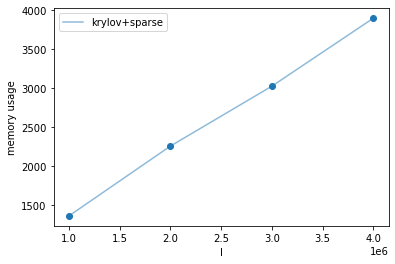

In [12]:
N_=1
#totol number of time step
mem_ma_Nfixed=[[],[]]
#first is average value,secind is standard deivation
h_dims=[1000000,2000000,3000000,4000000]
for dim in h_dims:
    mem_temp = %memit -r1 -i0.0001 -o get_memory_manually(N_,dim)
    mem_temp=np.array(mem_temp.mem_usage)
    mem_ma_Nfixed[0].append(np.average(mem_temp))
    mem_ma_Nfixed[1].append(np.std(mem_temp))
memory_plot(h_dims,mem_ma_Nfixed[0])
        

In [3]:
def memory_plot(h_dim,mem_usage):
    fig, ax = plt.subplots()
    x = (np.array(h_dims))**1
    y = np.array(mem_usage)
    fit = np.polyfit(x,y,1)
    ang_coeff = fit[0]
    intercept = fit[1]
    maximum_ma=(122070.312 -intercept)/ang_coeff
    fit_eq = ang_coeff*x + intercept  
    ax.scatter(x,y,color='C0')
    ax.plot(x, y,color='C0', alpha = 0.5, label = 'new_manual')
    ax.set_xlabel("l")
    ax.set_ylabel("memory usage")
    print('AD '+"slope is "+str(ang_coeff)+"and intercept is "+str(intercept))
    print("Max h_dim is "+ str(maximum_ma))
    ax.legend()

Manual:For 128GB RAM, Maximum Hilbert space dimension which is independent of total number of time step is 22228
AD:For 128GB RAM, Maximum Hilbert space dimension when total number of time step= 3 is 12614


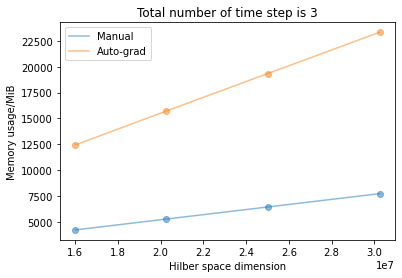

In [44]:
h_dim=[4000,4500,5000,5500]
mem_ma_Nfixed=[4203.80859375, 5252.3671875, 6423.37109375, 7716.8203125]
mem_ad_Nfixed=[12430.54296875, 15710.76953125, 19339.640625, 23349.51953125]
N_=3
fig, ax = plt.subplots()
x = (np.array(h_dim))**2
fit = np.polyfit(x,mem_ma_Nfixed,1)
ang_coeff = fit[0]
intercept = fit[1]
fit_eq = ang_coeff*x + intercept
maximum_ma=int(np.sqrt((122070.312 -intercept)/ang_coeff))
ax.plot(x, mem_ma_Nfixed, alpha = 0.5, label = 'Manual')
ax.scatter(x, mem_ma_Nfixed, alpha = 0.5)
print("Manual:For 128GB RAM, Maximum Hilbert space dimension which is independent of total number of time step is "+str(maximum_ma))

fit = np.polyfit(x,mem_ad_Nfixed,1)
ang_coeff = fit[0]
intercept = fit[1]
ax.plot(x, mem_ad_Nfixed, alpha = 0.5, label = 'Auto-grad')
ax.scatter(x, mem_ad_Nfixed, alpha = 0.5)
ax.set_ylabel ( "Memory usage/MiB")
ax.set_title('Total number of time step is '+str(N_))
maximum_ad=int(np.sqrt((122070.312 -intercept)/ang_coeff))
ax.set_xlabel ('Hilber space dimension')
print("AD:For 128GB RAM, Maximum Hilbert space dimension when total number of time step= "+str(N_) +' is '+ str(maximum_ad))
ax.legend()
plt.show()

In [ ]:
time_step=[3,6,9,12]
h_dim=4000
fig, ax = plt.subplots()
mem_ma_lfixed=[4203.80859375,4204.12890625,4204.19218363,4203.98647582,]
mem_ad_lfixed=[12430.54296875,19786.24,27175.96,34436.93,]

x = (np.array(time_step))
ax.plot(x, mem_ma_lfixed, alpha = 0.5, label = 'Manual')
ax.scatter(x, mem_ma_lfixed, alpha = 0.5)
ax.plot(x, mem_ad_lfixed, alpha = 0.5, label = 'Auto-grad')
ax.scatter(x, mem_ad_lfixed, alpha = 0.5)
ax.set_ylabel ( "Memory usage/MiB")
ax.set_title('Total number of time step is '+str(h_dim))

ax.set_xlabel ('Total time number of time step')
ax.legend()
plt.show()